# Weather Forecast - Modelling

## Import Data for Modelling

Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

Importing Data

In [2]:
filename = 'modelling_data.csv'
data_df = pd.read_csv(filename)
data_df.head()

,Date,Atmospheric Pressure,Minimum Temperature,Maximum Temperature,Relative Humidity,Wind Speed
0,2018-01-01,1019.5,16.3,26.1,25.333333,9.666667
1,2018-01-02,1019.6,16.1,27.4,27.583333,12.000000
2,2018-01-03,1019.9,15.7,27.2,24.416667,11.666667
3,2018-01-04,1021.4,16.0,29.0,27.166667,12.333333
4,2018-01-05,1021.2,14.2,26.9,29.916667,12.333333


Computing the Mean Temperature

In [3]:
data_df['Mean Temperature'] = pd.Series(np.mean([data_df['Minimum Temperature'], data_df['Maximum Temperature']], axis=0))
data_df.head()

,Date,Atmospheric Pressure,Minimum Temperature,Maximum Temperature,Relative Humidity,Wind Speed,Mean Temperature
0,2018-01-01,1019.5,16.3,26.1,25.333333,9.666667,21.20
1,2018-01-02,1019.6,16.1,27.4,27.583333,12.000000,21.75
2,2018-01-03,1019.9,15.7,27.2,24.416667,11.666667,21.45
3,2018-01-04,1021.4,16.0,29.0,27.166667,12.333333,22.50
4,2018-01-05,1021.2,14.2,26.9,29.916667,12.333333,20.55


In [4]:
data_df.shape

(1096, 7)

## LSTM - Weather Forecasting

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization, Bidirectional, Conv1D

from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.metrics import r2_score, mean_squared_error

from keras.layers import ConvLSTM2D

Using TensorFlow backend.


Convert DataFrame to Numpy Array

In [6]:
date_series = data_df['Date']
data_array = data_df.iloc[:, 1:].values
data_array.shape, data_array.dtype, date_series.shape

((1096, 6), dtype('float64'), (1096,))

Scaling of Dataset to avoid gradient explosion. 

__N.B:__ One importance of fit-transform is that the scaling can easily be inverted.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(data_array)
data_array = scaler.transform(data_array)
data_array.shape, data_array.dtype

((1096, 6), dtype('float64'))

Preparing the training and testing data for LSTM

In [8]:
def train_test_data_for_lstm(data, n_past, n_future=1, test_num=30, view_shape=False):
    """
    Function to determine the training and testing data for a recurrent neural network modelling.
    
    Input:
    data - numpy array of the data to be modelled
    n-past - the number of days in the past to be utilised for modelling
    n-future - the date in the future to be predicted.
    test_num - the number of days that would be used for model testing
    
    Output:
    train- a tuple containing the training features
    train - a tuple containing the training targets
    """
    
    # Define list to store X and Y datasets
    X = []
    Y = []
    
    for i in range(n_past, len(data) - n_future +1):
        X.append(data[i - n_past:i, 0:data.shape[1] - 1])
        Y.append(data[i + n_future - 1:i + n_future, data.shape[1] - 1])

    # Converting list to numpy array
    X, Y = np.array(X), np.array(Y)
    
    # Train-Test Split
    trainX = X[0:-test_num,:]
    testX = X[-test_num:len(data),:]
    
    trainY = Y[0:-test_num,:]
    testY = Y[-test_num:len(data),:]
    
    if view_shape:
        print('data shape == {}.'.format(data.shape))
        
        print('trainX shape == {}.'.format(trainX.shape))
        print('trainY shape == {}.'.format(trainY.shape))
        
        print('testX shape == {}.'.format(testX.shape))
        print('testY shape == {}.'.format(testY.shape))
        
    return (trainX, trainY), (testX, testY)   

In [9]:
(trainX, trainY), (testX, testY) = train_test_data_for_lstm(data_array, 21, 1, 30, True)

data shape == (1096, 6).
trainX shape == (1045, 21, 5).
trainY shape == (1045, 1).
testX shape == (30, 21, 5).
testY shape == (30, 1).


In [10]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 21, 32)            512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 100)           33200     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

In [11]:
weather_model = model.fit(trainX, trainY, epochs=5, batch_size=8, validation_split=0.1, verbose=1)

Train on 940 samples, validate on 105 samples
Epoch 1/5
940/940 [==============================] - 20s 21ms/step - loss: 0.0338 - val_loss: 0.0135
Epoch 2/5
940/940 [==============================] - 16s 17ms/step - loss: 0.0199 - val_loss: 0.0092
Epoch 3/5
940/940 [==============================] - 16s 16ms/step - loss: 0.0178 - val_loss: 0.0059
Epoch 4/5
940/940 [==============================] - 15s 16ms/step - loss: 0.0160 - val_loss: 0.0059
Epoch 5/5
940/940 [==============================] - 17s 18ms/step - loss: 0.0146 - val_loss: 0.0057


Plot the graph of the training loss and the validation loss for the developed model.

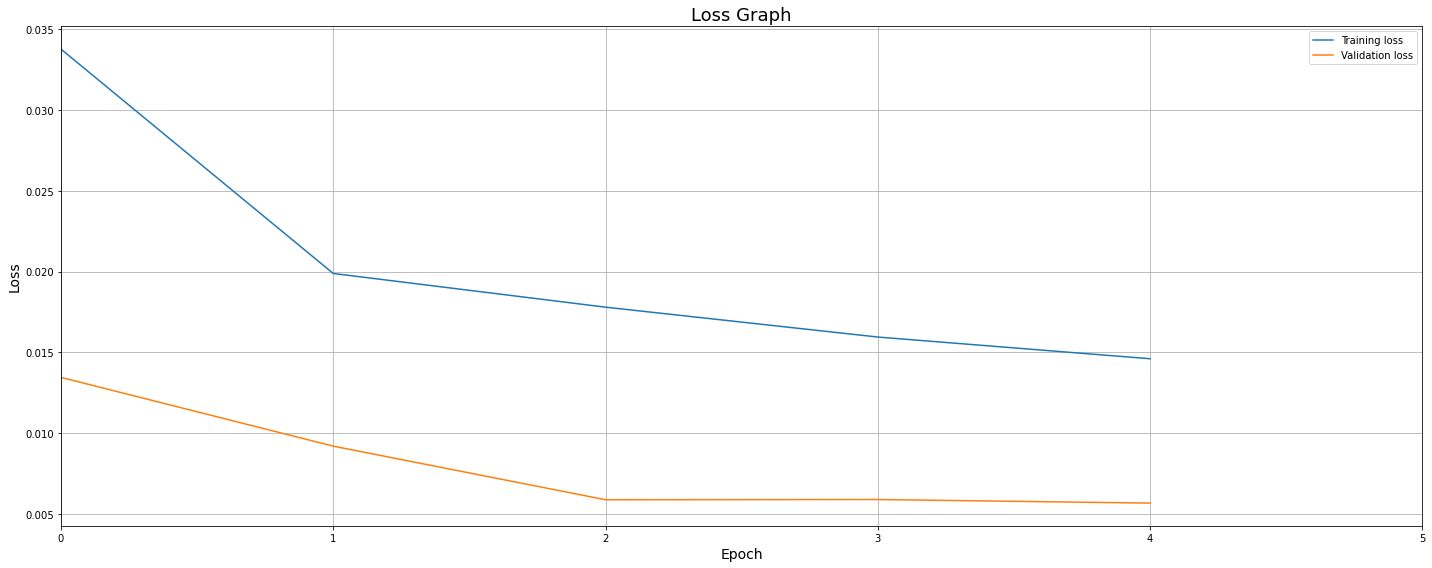

In [12]:
plt.figure(figsize=(20, 8))

plt.plot(weather_model.history['loss'], label='Training loss')
plt.plot(weather_model.history['val_loss'], label='Validation loss')

plt.title('Loss Graph', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

plt.xlim(0, len(weather_model.history['val_loss']))

plt.tight_layout()
plt.grid(True)

In [13]:
min(weather_model.history['loss']), min(weather_model.history['val_loss'])

(0.014613017223854649, 0.005683959989498059)

### Model Accuracy

In [14]:
def model_accuracy(model, testX, testY, view = False):
    
    y_pred = model.predict(testX)
    y_true = testY
    
    rmse = mean_squared_error(y_true, y_pred)
    r2score = r2_score(y_true, y_pred)
    
    if view:
        print(f'Root mean square error: {rmse}')
        print(f'R2 Score: {r2score}')
        
    return rmse, r2score    

In [15]:
model_accuracy(model, testX, testY, True)

Root mean square error: 0.007248462620430649
R2 Score: 0.16190548180363873


(0.007248462620430649, 0.16190548180363873)

### Forecasting

In [16]:
n_future = 30
forecast_dates = pd.date_range(list(date_series)[-n_future], periods=n_future, freq='1d')

forecast = model.predict(testX)

forecast_copies = np.repeat(forecast, data_array.shape[1], axis=1)

y_pred = scaler.inverse_transform(forecast_copies)[:, -1]

C:\Users\Olanrewaju Farooq\.conda\envs\envTensorFlow\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Olanrewaju Farooq\.conda\envs\envTensorFlow\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Olanrewaju Farooq\.conda\envs\envTensorFlow\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword wil

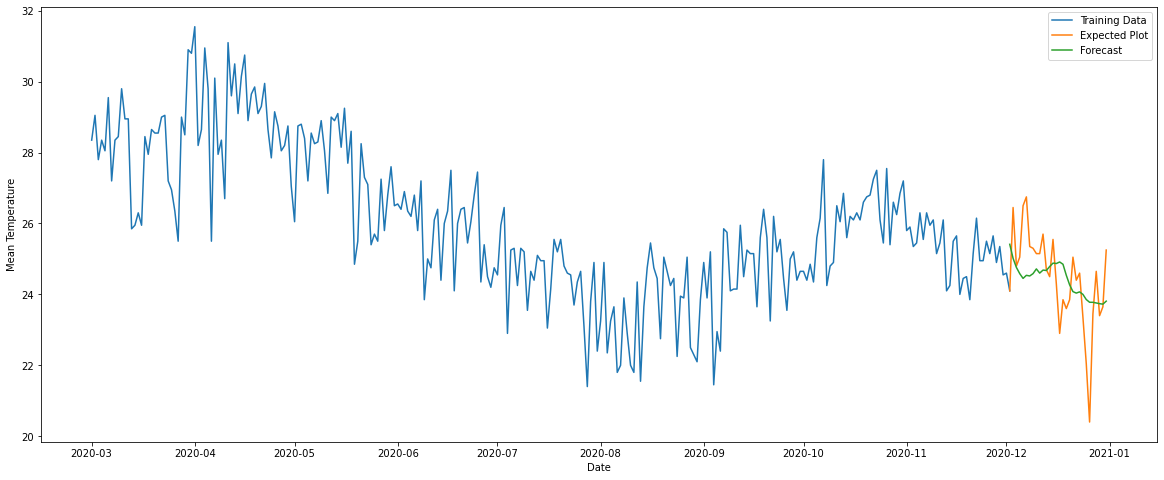

In [17]:
train_df = pd.DataFrame({'Date':np.array(data_df['Date'][0:-n_future+1]), 'Mean Temperature':np.array(data_df['Mean Temperature'][0:-n_future+1])})
test_df = pd.DataFrame({'Date':np.array(data_df['Date'][-n_future:]), 'Mean Temperature':np.array(data_df['Mean Temperature'][-n_future:])})
predict_df = pd.DataFrame({'Date':np.array(forecast_dates), 'Mean Temperature':y_pred})

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
predict_df['Date'] = pd.to_datetime(predict_df['Date'])

train_df = train_df.loc[train_df['Date'] >= '2020-3-1']


plt.figure(figsize=(20, 8))
sb.lineplot(train_df['Date'], train_df['Mean Temperature'])
sb.lineplot(test_df['Date'], test_df['Mean Temperature'])
sb.lineplot(predict_df['Date'], predict_df['Mean Temperature'])

plt.legend(['Training Data', 'Expected Plot', 'Forecast'])

### Hyperparameters Tuning

From the above graph, there is need for hyperparameter tuning to determine the best model to be used. 

We tune on the following parameters: 
1. Conv1D Filter (16, 32, 64)
2. Bidirectional LSTM units (25, 50, 75, 100)
3. Activation Function ('relu', 'tanh')
4. Dropout (0.1, 0.15, 0.2, 0.25)
5. Dense (of Fully-connected) Hidden Layer Units (100, 80, 64, 50, 32)
6. Batch Size (1, 8, 16, 32)
7. Validation Split (0.1, 0.15, 0.2)

In [19]:
def plot_loss_graph(weather_model, filters, lstm_unit, activation, dropout, hidden_layers, size, split):
    plt.figure(figsize=(20, 8))

    plt.plot(weather_model.history['loss'], label='Training loss')
    plt.plot(weather_model.history['val_loss'], label='Validation loss')

    plt.title(f'LOSS GRAPH. \n Filter: {filters} \t LSTM Units: {lstm_unit} \t Activation Function: {activation} \t Dropouts: {dropout} \t No of Hidden Fully Connected Layers: {hidden_layers} \t Batch Size: {size} \t Validation Split size: {split}', fontsize=18)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    plt.xlim(0, len(weather_model.history['val_loss']))

    plt.tight_layout()
    plt.grid(True)

In [20]:
def model_forecast(testX, data_df, date_Series, n_future = 30):
    
    forecast_dates = pd.date_range(list(date_series)[-n_future], periods=n_future, freq='1d')
    
    forecast = model.predict(testX)
    forecast_copies = np.repeat(forecast, data_array.shape[1], axis=1)
    y_pred = scaler.inverse_transform(forecast_copies)[:, -1]
    
    train_df = pd.DataFrame({'Date':np.array(data_df['Date'][0:-n_future+1]), 'Mean Temperature':np.array(data_df['Mean Temperature'][0:-n_future+1])})
    test_df = pd.DataFrame({'Date':np.array(data_df['Date'][-n_future:]), 'Mean Temperature':np.array(data_df['Mean Temperature'][-n_future:])})
    predict_df = pd.DataFrame({'Date':np.array(forecast_dates), 'Mean Temperature':y_pred})
    
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    test_df['Date'] = pd.to_datetime(test_df['Date'])
    predict_df['Date'] = pd.to_datetime(predict_df['Date'])
    
    train_df = train_df.loc[train_df['Date'] >= '2020-3-1']
    
    
    plt.figure(figsize=(20, 8))
    
    plt.title('Model Forecast Plot')
    
    sb.lineplot(train_df['Date'], train_df['Mean Temperature'])
    sb.lineplot(test_df['Date'], test_df['Mean Temperature'])
    sb.lineplot(predict_df['Date'], predict_df['Mean Temperature'])
    
    plt.legend(['Training Data', 'Expected Plot', 'Forecast'])

In [ ]:
list_filter = []
list_lstm_unit = []
list_activation = []
list_dropout = []
list_hidden_layers = []
list_size = []
list_split = []

list_model = []
list_weather_model = []

list_rmse = []
list_r2score = []
list_train_loss = []
list_val_loss = []

for filters in [16, 32]:
    for lstm_unit in [25, 50, 100]:
        for activation in ['relu', 'tanh']:
            for dropout in [0.1, 0.2, .3]:
                for hidden_layers in [100, 64, 50, 32]:
                    for size in [1, 8, 16, 32]:
                        for split in [0.1, 0.2, 0.3]:
                            
                            hidden_layers_ = int(hidden_layers/2)
                            
                            print(f"LSTM Model For:{filters} LSTM Units:{lstm_unit} Activation Function:{activation} Dropouts:{dropout} No of Hidden Fully Connected Layers:{hidden_layers} Batch Size:{size} Validation Split size:{split}")
                            
                            model = Sequential()
                            model.add(Conv1D(filters=filters, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=(trainX.shape[1], trainX.shape[2])))
                            model.add(Bidirectional(LSTM(lstm_unit, activation=activation, return_sequences=True)))
                            model.add(Bidirectional(LSTM(lstm_unit, activation=activation, return_sequences=True)))
                            model.add(Bidirectional(LSTM(lstm_unit, activation=activation, return_sequences=False)))
                            model.add(Dropout(dropout))
                            model.add(Dense(hidden_layers))
                            model.add(Dropout(dropout))
                            model.add(Dense(hidden_layers_))
                            model.add(Dropout(dropout))
                            model.add(Dense(trainY.shape[1]))
                            model.compile(optimizer='adam', loss='mse')
                            model.summary()
                            
                            weather_model = model.fit(trainX, trainY, epochs=15, batch_size=size, validation_split=split, verbose=1)
                            
                            rmse, r2score = model_accuracy(model, testX, testY, True)
                            plot_loss_graph(weather_model, filters, lstm_unit, activation, dropout, hidden_layers, size, split)
                            model_forecast(testX, data_df, date_Series, n_future = 30)                    
                            
                            train_loss = min(weather_model.history['loss'])
                            val_loss = min(weather_model.history['val_loss'])
                            
                            list_filter.append(filters)
                            list_lstm_unit.append(lstm_unit)
                            list_activation.append(activation)
                            list_dropout.append(dropout)
                            list_hidden_layers.append(hidden_layers)
                            list_size.append(size)
                            list_split.append(split)
                            
                            list_model.append(model)
                            list_weather_model.append(weather_model)
                            
                            list_rmse.append(rmse)
                            list_r2score.append(r2score)
                            list_eval_train_los.append(train_loss)
                            list_eval_train_loss.append(val_loss)
                            
                            print('\n\n\n\n\n\n\n')


hyperparameter_df = pd.DataFrame({'Convolution Filter':list_filter, 'LSTM Unit':list_lstm_unit, 'LSTM Activation Function':list_activation,
                                 'Dropout':list_dropout, 'Fully Connected Layers':list_hidden_layers, 'Batch Size':list_size, 'Validation Split':list_split,
                                 'Mean Square Error':list_rmse, 'R2 Score':list_r2score, 'Minimum Training Loss':list_train_loss, 'Minimum Validation Loss':list_val_loss})

hyperparameter_df.head()

LSTM Model For:16 LSTM Units:25 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:100 Batch Size:1 Validation Split size:0.1
ERROR! Session/line number was not unique in database. History logging moved to new session 174
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 21, 16)            256       
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_______